In [1]:
import sys

In [2]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools
import sys 
ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3
cosmo_params = pickle.load(open('data/cosmo_params.pkl', 'rb'))

In [3]:
def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [4]:
param_names = [ 'd1','e0' ,'e1','f0', 'g0','g1']

FIXED = {
         'f1':0.12,
         'd0':2.4,
        }

In [5]:
from os.path import exists
params = {}


ndim = len(param_names)
for box in cosmo_params:
    if('Box5_1400' in box): #something weird going on
        continue
    #check if there is a fit for this box by checking if the corresponding figure exsits
    fig_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f.pdf'%(box, 1.0)
    if(not exists(fig_fname)):
        print('Skipping %s'%(box))
        continue
    sampler = None
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "rb") as f:
        sampler = pickle.load(f)
    samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))
    final_param_vals = np.percentile(samples,  50,axis=0)
    params[box] = dict(zip(param_names, final_param_vals))

Skipping Box12_1400
Skipping Box15_1400
Skipping Box21_1400
Skipping Box22_1400
Skipping Box35_1400
Skipping Box36_1400
Skipping Box47_1400
Skipping Box49_1400
Skipping Box52_1400
Skipping Box54_1400
Skipping Box63_1400
Skipping Box70_1400
Skipping Box82_1400
Skipping Box85_1400
Skipping Box95_1400


In [6]:
from utils import *
import seaborn as sns
from tqdm import tqdm, trange

In [7]:
import random
box = 'Box_n50_0_1400'
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/emu_pred_for_%s.pkl"%(box), "rb") as f:
        pred_data = pickle.load(f)
a_list = list(pred_data.keys())

In [8]:
import matplotlib as mpl
import matplotlib.colors as mcolors
rainbow = mpl.colormaps['rainbow'].resampled(16)
rainbow_list = [mcolors.rgb2hex(rainbow(i)) for i in range(rainbow.N)]
colors = dict(zip(reversed(a_list), rainbow_list))
cmaps =  dict(zip(a_list, [sns.cubehelix_palette(start=s, light=1, as_cmap=True) for s in np.linspace(0, 3, len(a_list))]))


In [86]:
print(pred_data[a].keys())

dict_keys(['Ms, N, Edges', 'emulataor_sampled_NvM', 'emulataor_sampled_residual', 'emulataor_mean_NvM', 'emulataor_mean_residual', 'MLFit_NvM', 'MLFit_residual', 'train/test'])


In [151]:
data = {}
data['train'] = {}
data['test'] = {}

for a in (a_list):
    data['train'][a] = []
for a in (a_list):
    data['test'][a] = []


for box in tqdm(params):
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/emu_pred_for_%s.pkl"%(box), "rb") as f:
        pred_data = pickle.load(f)
    cls = pred_data[1.0]['train/test']
    for a in pred_data:
        Ms, N, edges = pred_data[a]['Ms, N, Edges']
        uncertainty_estimate = pred_data[a]['emulataor_sampled_NvM']
#         uncertainty_estimate = [pred_data[a]['MLFit_NvM']]

        for result_idx in range(len(uncertainty_estimate)):
            result = uncertainty_estimate[result_idx]
            if(pred_data[1.0]['train/test'] == 'train' and result_idx > len(uncertainty_estimate)/10):
                break
            if(pred_data[1.0]['train/test'] == 'test' and result_idx > len(uncertainty_estimate)/1):
                break

            residual = (result-N)/N
            assert(len(Ms) == len(residual))
            for m, res in zip(Ms, residual):
                data[cls][a] += [[m, res]]

100%|██████████| 134/134 [00:16<00:00,  8.14it/s]


In [152]:
import seaborn as sns

In [153]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20
plt.rcParams['text.usetex'] = True

/tmp/ipykernel_1289/3026309896.py:15: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(0, c='black')
/tmp/ipykernel_1289/3026309896.py:24: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axhline(0, c='black')


dict_keys([1.0, 0.953321, 0.866399, 0.787402, 0.715608, 0.65036, 0.620002, 0.591061, 0.563471, 0.537169, 0.512095, 0.488191, 0.403224, 0.366459, 0.302679, 0.25])


100%|██████████| 2/2 [00:04<00:00,  2.00s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done plotting


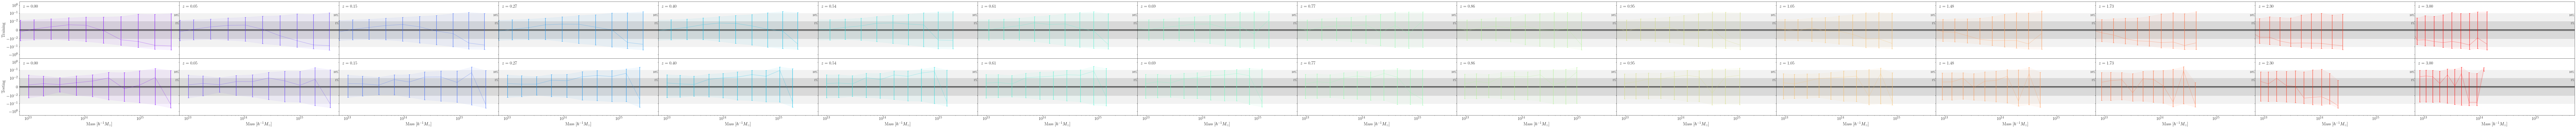

In [157]:
fig, axs_tmp = plt.subplots(nrows=2, ncols=16, figsize=(160,8), sharex=True, sharey=True)
# print(axs_tmp.shape)
# axs_tmp= axs_tmp.T


from scipy.stats import binned_statistic 

for ax in axs_tmp.flatten():
    ax.set_ylim((-3e0, 3e0))
    ax.set_xlim((1e12, 1e16))

    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1e-2) 
#     ax.set_yticks([])
    ax.axhline(0, c='black')
#     ax.axhline(0.1, c='0.7',)
#     ax.axhline(-0.1, c='0.7',label='10% Error')
#     ax.axhline(0.01, c='0.5', )
#     ax.axhline(-0.01, c='0.5', label='1% Error')
    ax.fill_between([0, 1e20], [-0.1, -0.1], [0.1, 0.1], alpha=1, color='0.95')#, label=r'$<10\%$ Error')
    ax.fill_between([0, 1e20], [-0.01, -0.01], [0.01, 0.01], alpha=1, color='0.85')#, label=r'$<1\%$ Error')
    ax.fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.65')#, label=r'$<0.1\%$ Error')

    ax.axhline(0, c='black')

fig.tight_layout() 


plt.subplots_adjust(wspace=0, hspace=0)

axs = {}
axs['train'] = {}
axs['test'] = {}
for a, ax in zip(reversed(a_list), axs_tmp[0]):
    axs['train'][a] = ax
    ax.text(.02, 0.95, r'$z=%.2f$'%(scaleToRedshift(a)),
           transform=ax.transAxes,
            horizontalalignment='left',
            verticalalignment='top',)
    ax.text(5e15, .8e-1, r'$10\%$',
            horizontalalignment='right',
            verticalalignment='top',fontsize=13)
    ax.text(5e15, .9e-2, r'$1\%$',
            horizontalalignment='right',
            verticalalignment='top',fontsize=13)
#     ax.text(5e15, .83e-3, r'$0.1\%$',
#             horizontalalignment='right',
#             verticalalignment='top',fontsize=13)
    
    
    
for a, ax in zip(reversed(a_list), axs_tmp[1]):
    axs['test'][a] = ax
    ax.text(.02, 0.95, r'$z=%.2f$'%(scaleToRedshift(a)),
           transform=ax.transAxes,
            horizontalalignment='left',
            verticalalignment='top',)
    ax.text(5e15, .8e-1, r'$10\%$',
            horizontalalignment='right',
            verticalalignment='top',fontsize=13)
    ax.text(5e15, .9e-2, r'$1\%$',
            horizontalalignment='right',
            verticalalignment='top',fontsize=13)
#     ax.text(5e15, .83e-3, r'$0.1\%$',
#             horizontalalignment='right',
#             verticalalignment='top',fontsize=13)
    
    
# axs['test'][0.25].set_xlabel(r'Mass $[h^{-1}M_\odot]$')

print(axs['test'].keys())
import matplotlib.patches as  mpatches
import matplotlib.lines as  mlines

for key in tqdm(data):
    for a in reversed(data[key]):
        ax = axs[key][a]
        curr_data = np.array(data[key][a])
#         print(curr_data.shape)
        X,Y  = curr_data.T
        
        nBins = 10
#         print(np.min(X))
        bin_centers, bin_edges, _ = binned_statistic(np.log10(X), np.log10(X), statistic='mean', bins=nBins)
        stds, bin_edges, _ = binned_statistic(np.log10(X), Y, statistic='std', bins=nBins)
        means, bin_edges, _ = binned_statistic(np.log10(X), Y, statistic='mean', bins=nBins)
        
    
        ax.errorbar(10**(bin_centers),
                    means,
                    yerr=stds,
                    c=colors[a], alpha=1, fmt=':', capsize=3,
                    capthick=1)
        tmp_data = {
           'x': 10**(bin_centers),
           'y1': [y - e for y, e in zip((means), stds)],
           'y2': [y + e for y, e in zip((means), stds)]}
        ax.fill_between(**tmp_data, color=colors[a], alpha=.05)

#         ax.scatter(X,Y, color=colors[a], alpha=0.005, s=5)
        if(key=='test'):
            ax.set_xlabel(r'Mass $[h^{-1}M_\odot]$')
#         sns.kdeplot(x=X, y=Y, levels=[1-.393], ax=ax, color='k')#,label='kde')
        ax.set_xlim([7e12, 5e15])
    
        
    
print('Done plotting')
        
axs['train'][1.0].legend(frameon=False, loc='lower left')
axs['test'][1.0].legend(frameon=False, loc='lower left')


axs['train'][1.0].set_ylabel('Training')
axs['test'][1.0].set_ylabel('Testing')


plt.savefig('meta_emu_perf.png', bbox_inches='tight')
# plt.savefig('meta_emu_perf.pdf', bbox_inches='tight')

<Axes: >

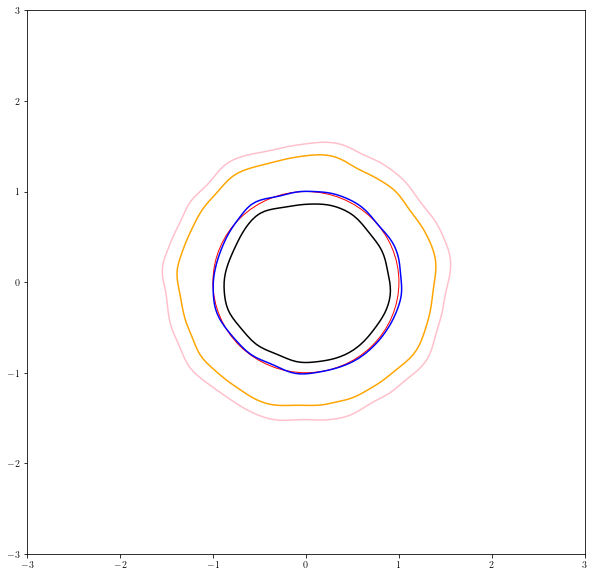

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
X = np.random.normal(size=[100000])
Y = np.random.normal(size=[100000])
# ax.scatter(X,Y, alpha=0.05)
circle1 = plt.Circle((0, 0), 1, color='r', fill=False)
ax.add_patch(circle1)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
kde = sns.kdeplot(x=X, y=Y, levels=[.393], ax=ax, color='orange')#,label='kde')
kde = sns.kdeplot(x=X, y=Y, levels=[1-.393], ax=ax, color='blue')#,label='kde') 
#39.3%, see https://corner.readthedocs.io/en/latest/pages/sigmas/, 
 
kde = sns.kdeplot(x=X, y=Y, levels=[.6827], ax=ax, color='k')#,label='kde')
sns.kdeplot(x=X, y=Y, levels=[1-.6827], ax=ax, color='pink')#,label='kde')

#seems like the blue contour is the correct way to get one sigma contour